In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
# from torchinfo import summary
from torchsummary import summary
import argparse
import time
import os
from model import LSTMModel, CNN_LSTM, DSTNET, LSTMNet, CNN_LSTM_AR, DSTNETV2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# parser = argparse.ArgumentParser(description='Add these argument for training')
# parser.add_argument('--dir', default='results', help='directory for saving trianed mode')
# parser.add_argument('--feature', required= True)

# parser.add_argument('--lr', default=0.005, help='learning rate')
# parser.add_argument('--epochs', default=10, help='epoch number')
# parser.add_argument('--batch_size', default=32)
# args = parser.parse_args()

# ## Set parameter for the model
# directory = args.dir                # directory for saving model
# batch_size = int(args.batch_size)   # batch size
# learning_rate = float(args.lr)
# num_epochs = int(args.epochs)

### **Data Processing**

In [4]:
data = pd.read_csv('data/solar_wind_parameters_data_1_hourly_all.csv')
print(data.shape)
# data = data.drop(columns=['Unnamed: 0','Timestamp'])

data.head()

(212088, 15)


,Unnamed: 0,Timestamp,YEAR,DOY,HR,Scalar_B,BX_GSE_GSM,BY_GSE,BZ_GSE,BY_GSM,BZ_GSM,Proton_Density,SW_Plasma_Temperature,SW_Plasma_Speed,Dst-index
0,0,1999-1-0,1999,1,0,6.792,-1.686,2.710,5.118,1.284,5.650,6.070,81042.0,415.28,-7.0
1,1,1999-1-1,1999,1,1,6.884,-4.513,0.390,3.240,-0.361,3.255,7.027,90525.0,400.50,-4.0
2,2,1999-1-2,1999,1,2,7.073,-3.813,-0.826,4.949,-1.808,4.681,6.793,88927.0,405.24,-4.0
3,3,1999-1-3,1999,1,3,6.644,-3.535,1.860,0.244,1.753,0.515,7.129,104190.0,413.07,-8.0
4,4,1999-1-4,1999,1,4,6.645,-3.082,1.953,2.664,1.730,2.866,6.963,101510.0,415.57,-8.0


In [5]:
features = ['Scalar_B', 'BX_GSE_GSM', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM', 'Proton_Density', 'SW_Plasma_Temperature', 'SW_Plasma_Speed']
# features = ['Scalar_B', 'BZ_GSE', 'BZ_GSM', 'Proton_Density', 'SW_Plasma_Temperature', 'SW_Plasma_Speed']
target = ['Dst-index']

# Select the features and target
data = data[features + target]
# data.head()
X = data[features].values
y = data[target].values

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=21, shuffle=False)

# Scale X
scaler_X = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale y (if regression)
scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# merge X and y
train_data = np.concatenate((X_train_scaled, y_train_scaled), axis=1)
test_data = np.concatenate((X_test_scaled, y_test_scaled), axis=1)

# Split the data into sequences
def sequence(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1]) # all columns except the last
        y.append(data[i+seq_length, -1])  # target is the last column
        # print(f'X:{np.array(X)}, Y:{np.array(y)}')
    return np.array(X), np.array(y)

SEQ_LENGTH = 24
X_train, y_train = sequence(train_data, SEQ_LENGTH)
X_test, y_test = sequence(test_data, SEQ_LENGTH)

X shape: (212088, 9)
y shape: (212088, 1)


In [6]:
test_df = pd.DataFrame(test_data, columns=features + target)
test_df.head()

,Scalar_B,BX_GSE_GSM,BY_GSE,BZ_GSE,BY_GSM,BZ_GSM,Proton_Density,SW_Plasma_Temperature,SW_Plasma_Speed,Dst-index
0,-0.856786,0.167112,-0.106477,0.167391,0.044841,0.098193,-0.783340,-0.963921,-0.760462,0.204545
1,-0.839442,0.154424,-0.128488,0.151360,0.027201,0.083876,-0.792527,-0.964690,-0.759713,0.215909
2,-0.834339,0.151548,-0.145919,0.152538,0.016184,0.084231,-0.811995,-0.963183,-0.759775,0.181818
3,-0.849983,0.167973,-0.092349,0.160894,0.071632,0.091043,-0.813894,-0.954634,-0.764919,0.113636
4,-0.821987,0.152327,-0.169377,0.151305,0.004097,0.079362,-0.813894,-0.939933,-0.749279,0.090909


In [7]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'X_test_tensor shape: {X_test_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')

# Create a DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

X_train_tensor shape: torch.Size([209943, 24, 9])
y_train_tensor shape: torch.Size([209943])
X_test_tensor shape: torch.Size([2097, 24, 9])
y_test_tensor shape: torch.Size([2097])


### **Model**

**DSTNETV2**

In [8]:

learning_rate = 0.0001
directory = 'results/run13'

input_size = len(features)
# self, input_size, hidden_size=650, num_layers=2, output_size=1, kl_weight=0.0001, dropout=0.4
hidden_layer_size = 648
output_size = 1
model = DSTNETV2(
    input_size=input_size,
    hidden_size=hidden_layer_size,
    # num_layers=2,
    output_size=output_size,
    kl_weight=0.0001,
    dropout=0.4
).to(device)
# print(f'Model: {model} input_size: {input_size}, hidden_layer_size: {hidden_layer_size}, output_size: {output_size}')
print(summary(model, input_size=(batch_size, SEQ_LENGTH, input_size)))

criterion = nn.MSELoss()


Input shape: torch.Size([2, 32, 24, 9])


RuntimeError: shape '[32, 24, 9]' is invalid for input of size 13824

### **Training Loop**

In [ ]:

num_epochs = 150
future_steps = 6
accumulation_steps = 4  # Accumulate gradients for larger effective batch size
scaler = torch.amp.GradScaler("cuda")  # For mixed precision training

from torch.optim.lr_scheduler import OneCycleLR

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
total_steps = len(train_loader) * num_epochs

scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-4,
    total_steps=total_steps,
    pct_start=0.1,  # Warmup for 10% of training
    div_factor=50,  # Initial lr = max_lr/25
    final_div_factor=100,  # Less aggressive final lr reduction
    anneal_strategy='cos'  # Cosine annealing
)

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(f'./{directory}/runs')

# # Add the results directory to .gitignore
# with open('.gitignore', 'a') as f:
#     f.write(f'\n{directory}/runs')

def check_data_statistics(loader):
    all_data = []
    for X, _ in loader:
        all_data.append(X.cpu().numpy())
    all_data = np.concatenate(all_data, axis=0)
    
    print("Data Statistics:")
    print(f"Mean: {np.mean(all_data):.4f}")
    print(f"Std: {np.std(all_data):.4f}")
    print(f"Min: {np.min(all_data):.4f}")
    print(f"Max: {np.max(all_data):.4f}")

check_data_statistics(train_loader)
check_data_statistics(test_loader)


# Training Loop
train_losses = []
test_losses = []
train_loss = 0.0
test_loss = 0.0

best_loss = float('inf')
patience_counter = 0
patience = 15

best_epoch = 0
rec = []

patience = 15
patience_counter = 0

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for i, (X_train, y_train) in enumerate(train_loader):
        with torch.amp.autocast("cuda"):
            y_pred = model(X_train, future_steps=future_steps)
            y_target = y_train.unsqueeze(1).expand(-1, future_steps)
            y_pred = y_pred.squeeze(-1)
            loss = criterion(y_pred, y_target)
            loss = loss / accumulation_steps
        
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # writer.add_scalar('Gradient Norm', grad_norm, epoch)
        # writer.add_scalar('Learning Rate', scheduler.get_last_lr()[0], epoch)
        # writer.add_scalar('Train Loss', train_loss, epoch)
        # writer.add_scalar('Test Loss', test_loss, epoch)
        
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)  # First optimizer step
            scheduler.step()        # Then scheduler step
            scaler.update()
            optimizer.zero_grad()
        
        running_loss += loss.item() * accumulation_steps
    
    end = time.time()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Test the model
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred = model(X_test, future_steps=future_steps)
            y_pred = y_pred.squeeze(-1) # [batch, future_steps]
            y_target = y_test.unsqueeze(1).expand(-1, future_steps)  # Shape: [batch, future_steps]
            loss = criterion(y_pred, y_target)
            test_loss += loss.item()
    
    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    # Early stopping
    if test_loss < best_loss:  # Remove the 0.995 multiplier
        improvement = (best_loss - test_loss) / best_loss * 100
        best_loss = test_loss
        patience_counter = 0
        
        if improvement > 0.1:  # Only save if improvement is significant (0.1%)
            print(f"Model improved by {improvement:.2f}% from {best_loss:.4f} to {test_loss:.4f}. Saving model...")
            best_epoch = epoch + 1
            
            checkpoint = {
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': best_loss,
                'input_size': model.input_size,
                'hidden_size': model.hidden_size,
                'num_layers': model.num_layers,
            }
            torch.save(checkpoint, f'./{directory}/model{round(best_loss*10000)}.pth')
            torch.save(checkpoint, f'./{directory}/best_model.pth')
    else:
        patience_counter += 1

    if patience_counter > patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Adjust learning rate
    # scheduler.step(test_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {end-start:.2f} sec")

    if epoch % 5 == 0:  # Plot every 5 epochs
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'./{directory}/learning_curve.png')
        plt.close()    

    # Record results
    rec.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'test_loss': test_loss,
    })

# Write results to csv
df = pd.DataFrame(rec)
df.to_csv(f'{directory}/results.csv', index=False)

print(f"Finihsed training after {num_epochs} epochs. Best loss: {best_loss:.4f} at epoch {best_epoch}")

Data Statistics:
Mean: -0.2947
Std: 0.4728
Min: -1.0000
Max: 1.0000
Data Statistics:
Mean: -0.3063
Std: 0.4769
Min: -0.9977
Max: 0.6636
Epoch [1/150], Train Loss: 0.0441, Test Loss: 0.0211, Time: 34.89 sec
Epoch [2/150], Train Loss: 0.0441, Test Loss: 0.0211, Time: 35.07 sec
Epoch [3/150], Train Loss: 0.0441, Test Loss: 0.0211, Time: 34.76 sec
Model improved by 0.10% from 0.0211 to 0.0211. Saving model...
Epoch [4/150], Train Loss: 0.0442, Test Loss: 0.0211, Time: 34.60 sec
Epoch [5/150], Train Loss: 0.0442, Test Loss: 0.0211, Time: 35.02 sec
Model improved by 0.17% from 0.0211 to 0.0211. Saving model...
Epoch [6/150], Train Loss: 0.0442, Test Loss: 0.0211, Time: 34.80 sec
Model improved by 0.14% from 0.0210 to 0.0210. Saving model...
Epoch [7/150], Train Loss: 0.0442, Test Loss: 0.0210, Time: 34.98 sec
Epoch [8/150], Train Loss: 0.0442, Test Loss: 0.0210, Time: 34.71 sec
Epoch [9/150], Train Loss: 0.0442, Test Loss: 0.0210, Time: 34.56 sec
Epoch [10/150], Train Loss: 0.0441, Test Loss

### **Test the Result**

Load Checkpoint (Optional)

In [ ]:
# Load the trained model
# path = 'results/run4/best_model.pth'
# checkpoint = torch.load(f'{path}', map_location=device)
# print(checkpoint.keys())

# # Recreate the model
# model = LSTMModel(checkpoint['input_size'], checkpoint['hidden_size'], output_size=1).to(device)

# Load the model weights
# model.load_state_dict(checkpoint['model_state_dict'])
# model.eval()  # Set to evaluation mode

# print("Model loaded successfully!")

In [ ]:

# Predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor, future_steps=future_steps)
    # y_pred = model(X_train, future_steps=future_steps)
    # print(f'y_pred:{y_pred.shape} {y_pred}')

# Convert true values to NumPy
y_test = y_test_tensor.cpu().numpy()

# Fix the shape by flattening y_pred
y_pred = y_pred.cpu().numpy().flatten()
# print(f'y_pred:{y_pred.shape} {y_pred}')

# Inverse transform the scaled values
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

print(f'y_pred_original:{y_pred_original.shape} {y_pred_original}')

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_original, y_pred_original)
print(f'MSE: {mse:.2f}')


OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB. GPU 0 has a total capacity of 23.53 GiB of which 49.31 MiB is free. Process 173304 has 22.00 GiB memory in use. Including non-PyTorch memory, this process has 1.43 GiB memory in use. Of the allocated memory 784.27 MiB is allocated by PyTorch, and 201.73 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Plot

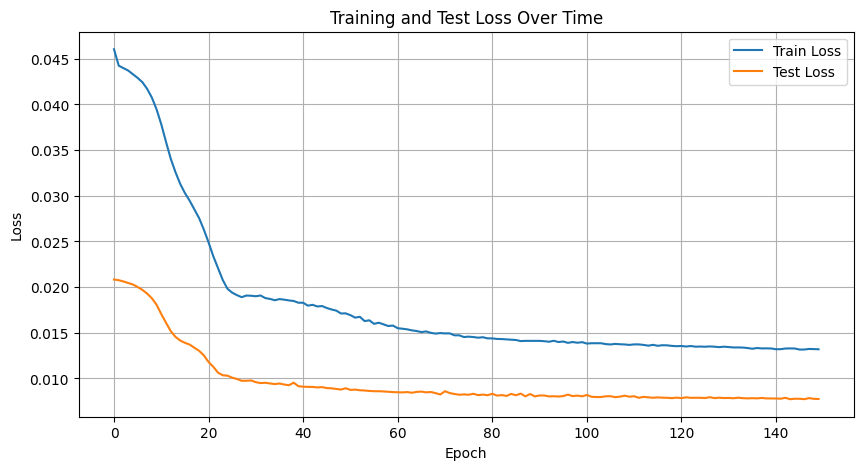

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

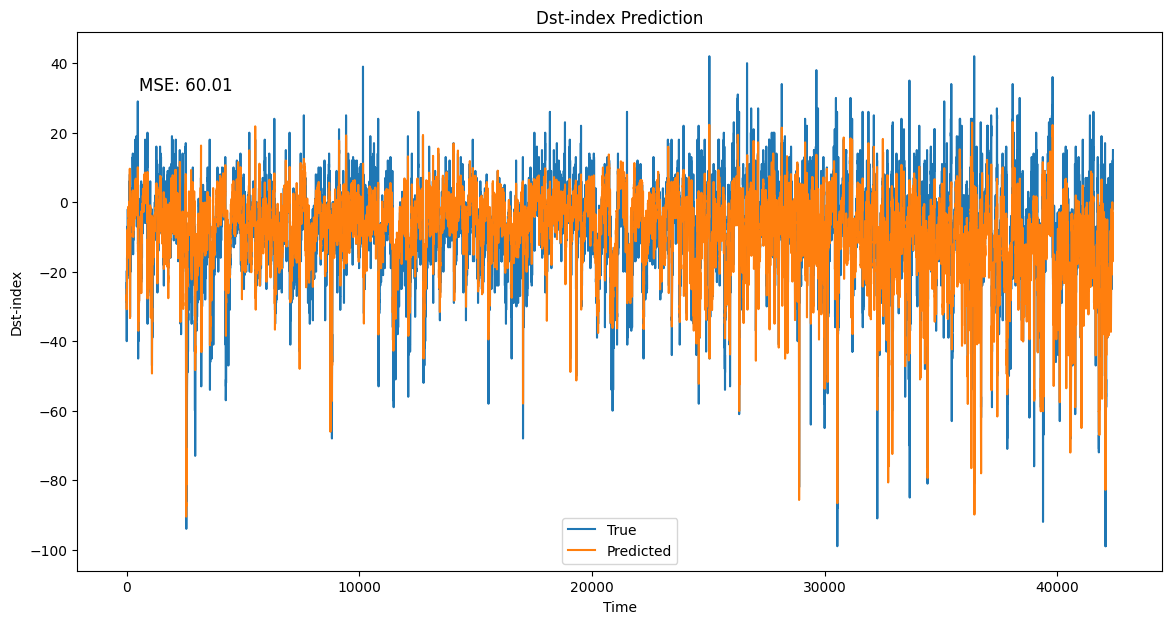

In [ ]:
# Plot the results
plt.figure(figsize=(14, 7))

# Add MSE to graph
plt.text(0.1, 0.9, f'MSE: {mse:.2f}', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.plot(y_test_original, label='True')
plt.plot(y_pred_original, label='Predicted')
plt.title('Dst-index Prediction')
plt.xlabel('Time')
plt.ylabel('Dst-index')
plt.legend()
plt.savefig(f'{directory}/prediction.png')
plt.show()